In [1]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf

In [2]:
# Read in csv file
df = pd.read_csv('GPTarget2024.csv')

# drop all rows where the religious_affiliation column is other or prefer_not_to_say
df = df[df.religious_affiliation != 'other']
df = df[df.religious_affiliation != 'prefer_not_to_say']

In [3]:
# Create new dataframes split by issue
df_digital_privacy = df[df['issue_stance'] == "The U.S. should not implement legislation that strengthens digital privacy rights"]
df_renewable_energy = df[df['issue_stance'] == "The U.S. should increase investments in renewable energy technologies."]
df_china_sanctions = df[df['issue_stance'] == "The U.S. should impose stronger economic sanctions on China."]
df_nato_support = df[df['issue_stance'] == "The U.S. should not increase its support for NATO."]

In [4]:
# Split by religious affiliation
df_religious = df[~df['religious_affiliation'].isin(['agnostic', 'atheist'])]
df_non_religious = df[df['religious_affiliation'].isin(['agnostic', 'atheist'])]

df_digital_privacy_religious = df_digital_privacy[~df_digital_privacy['religious_affiliation'].isin(['agnostic', 'atheist'])]
df_digital_privacy_non_religious = df_digital_privacy[df_digital_privacy['religious_affiliation'].isin(['agnostic', 'atheist'])]

df_renewable_energy_religious = df_renewable_energy[~df_renewable_energy['religious_affiliation'].isin(['agnostic', 'atheist'])]
df_renewable_energy_non_religious = df_renewable_energy[df_renewable_energy['religious_affiliation'].isin(['agnostic', 'atheist'])]

df_china_sanctions_religious = df_china_sanctions[~df_china_sanctions['religious_affiliation'].isin(['agnostic', 'atheist'])]
df_china_sanctions_non_religious = df_china_sanctions[df_china_sanctions['religious_affiliation'].isin(['agnostic', 'atheist'])]

df_nato_support_religious = df_nato_support[~df_nato_support['religious_affiliation'].isin(['agnostic', 'atheist'])]
df_nato_support_non_religious = df_nato_support[df_nato_support['religious_affiliation'].isin(['agnostic', 'atheist'])]

In [5]:
# Define the issues and a category for all issues
issues = ['digital_privacy', 'renewable_energy', 'china_sanctions', 'nato_support', 'all_issues']
affiliations = ['religious', 'non_religious']

# Dictionary to hold the models and results
models = {}
results = {}

# Loop over each issue and religious affiliation to create and fit the models
for issue in issues:
    for affiliation in affiliations:
        # Special handling for the 'all_issues' category
        if issue == 'all_issues':
            df_name = f'df_{affiliation}'
        else:
            df_name = f'df_{issue}_{affiliation}'
        
        # Access the dataframe from the locals() dictionary
        df = locals()[df_name]
        
        # Define the formula
        formula = 'dv_response_mean ~ Q("microtargeting") + Q("false microtargeting") + Q("no microtargeting") + political_party_coded + political_ideology_coded + political_engagement_coded'
        
        # Create and fit the model
        models[df_name] = smf.ols(formula=formula, data=df)
        results[df_name] = models[df_name].fit()

# Now you can access each result using the results dictionary
# For example, to access the result for digital privacy issues for religious:
result_digital_privacy_religious = results['df_digital_privacy_religious']
result_digital_privacy_non_religious = results['df_digital_privacy_non_religious']
result_renewable_energy_religious = results['df_renewable_energy_religious']
result_renewable_energy_non_religious = results['df_renewable_energy_non_religious']
result_china_sanctions_religious = results['df_china_sanctions_religious']
result_china_sanctions_non_religious = results['df_china_sanctions_non_religious']
result_nato_support_religious = results['df_nato_support_religious']
result_nato_support_non_religious = results['df_nato_support_non_religious']
result_all_issues_religious = results['df_religious']
result_all_issues_non_religious = results['df_non_religious']

In [6]:
# Create a dataframe to store the results for plotting
issues_models = {
    'Digital Privacy Religious': results['df_digital_privacy_religious'],
    'Digital Privacy Non-Religious': results['df_digital_privacy_non_religious'],
    'Renewable Energy Religious': results['df_renewable_energy_religious'],
    'Renewable Energy Non-Religious': results['df_renewable_energy_non_religious'],
    'China Sanctions Religious': results['df_china_sanctions_religious'],
    'China Sanctions Non-Religious': results['df_china_sanctions_non_religious'],
    'NATO Support Religious': results['df_nato_support_religious'],
    'NATO Support Non-Religious': results['df_nato_support_non_religious']
}

# Initialize an empty list to store the data
data = []

# Iterate over the dictionary to extract the data
for issue, model in issues_models.items():
    # Extract the coefficients and the confidence intervals
    coef = model.params
    conf_int = model.conf_int()
    
    # Determine the religious affiliation from the issue key
    affiliation = 'Religious' if 'Religious' in issue else 'Non-Religious'
    
    # Iterate over the coefficients
    for covariate in ['microtargeting', 'false microtargeting', 'no microtargeting']:
        # Use the Q function label format
        q_covariate = f'Q("{covariate}")'
        # Skip if the covariate is not in the model
        if q_covariate not in coef:
            continue
        # Get the coefficient and confidence interval
        coefficient = coef[q_covariate]
        lower_ci, upper_ci = conf_int.loc[q_covariate]
        
        # Append the data to the list
        data.append({
            'Covariate': covariate,
            'Issue': issue.replace(' Religious', '').replace(' Non-Religious', ''),
            'Affiliation': affiliation,
            'Coefficient': coefficient,
            '95% CI Lower': lower_ci,
            '95% CI Upper': upper_ci
        })

# Create a DataFrame from the list
results_df = pd.DataFrame(data)

In [7]:
def compute_weighted_stats(term, models):
    coefficients = np.array([model.params[term] for model in models])
    standard_errors = np.array([model.bse[term] for model in models])

    weights = 1 / standard_errors**2
    weighted_mean = np.sum(coefficients * weights) / np.sum(weights)
    weighted_variance = 1 / np.sum(weights)
    weighted_std_error = np.sqrt(weighted_variance)

    z_critical = scipy.stats.norm.ppf(0.975)  # 97.5th percentile for two-tailed test
    confidence_interval = (weighted_mean - z_critical * weighted_std_error, 
                           weighted_mean + z_critical * weighted_std_error)

    return weighted_mean, confidence_interval

# Separate the models by religious affiliation
religious_models = [results['df_digital_privacy_religious'], results['df_renewable_energy_religious'], results['df_china_sanctions_religious'], results['df_nato_support_religious']]
non_religious_models = [results['df_digital_privacy_non_religious'], results['df_renewable_energy_non_religious'], results['df_china_sanctions_non_religious'], results['df_nato_support_non_religious']]

# Compute the weighted stats for religious
microtargeting_mean_religious, microtargeting_ci_religious = compute_weighted_stats('Q("microtargeting")', religious_models)
false_microtargeting_mean_religious, false_microtargeting_ci_religious = compute_weighted_stats('Q("false microtargeting")', religious_models)
no_microtargeting_mean_religious, no_microtargeting_ci_religious = compute_weighted_stats('Q("no microtargeting")', religious_models)

# Compute the weighted stats for non-religious
microtargeting_mean_non_religious, microtargeting_ci_non_religious = compute_weighted_stats('Q("microtargeting")', non_religious_models)
false_microtargeting_mean_non_religious, false_microtargeting_ci_non_religious = compute_weighted_stats('Q("false microtargeting")', non_religious_models)
no_microtargeting_mean_non_religious, no_microtargeting_ci_non_religious = compute_weighted_stats('Q("no microtargeting")', non_religious_models)

# Create a list of dictionaries for the new rows, separating by religious affiliation
weighted_stats_religious = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (Religious)', 'Affiliation': 'Religious', 'Coefficient': microtargeting_mean_religious, '95% CI Lower': microtargeting_ci_religious[0], '95% CI Upper': microtargeting_ci_religious[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (Religious)', 'Affiliation': 'Religious', 'Coefficient': false_microtargeting_mean_religious, '95% CI Lower': false_microtargeting_ci_religious[0], '95% CI Upper': false_microtargeting_ci_religious[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (Religious)', 'Affiliation': 'Religious', 'Coefficient': no_microtargeting_mean_religious, '95% CI Lower': no_microtargeting_ci_religious[0], '95% CI Upper': no_microtargeting_ci_religious[1]}
]

weighted_stats_non_religious = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (Non-Religious)', 'Affiliation': 'Non-Religious', 'Coefficient': microtargeting_mean_non_religious, '95% CI Lower': microtargeting_ci_non_religious[0], '95% CI Upper': microtargeting_ci_non_religious[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (Non-Religious)', 'Affiliation': 'Non-Religious', 'Coefficient': false_microtargeting_mean_non_religious, '95% CI Lower': false_microtargeting_ci_non_religious[0], '95% CI Upper': false_microtargeting_ci_non_religious[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (Non-Religious)', 'Affiliation': 'Non-Religious', 'Coefficient': no_microtargeting_mean_non_religious, '95% CI Lower': no_microtargeting_ci_non_religious[0], '95% CI Upper': no_microtargeting_ci_non_religious[1]}
]

# Convert the lists of dictionaries to DataFrames
weighted_stats_religious_df = pd.DataFrame(weighted_stats_religious)
weighted_stats_non_religious_df = pd.DataFrame(weighted_stats_non_religious)

# Append the new DataFrames to the existing results_df
results_df = pd.concat([results_df, weighted_stats_religious_df, weighted_stats_non_religious_df], ignore_index=True)


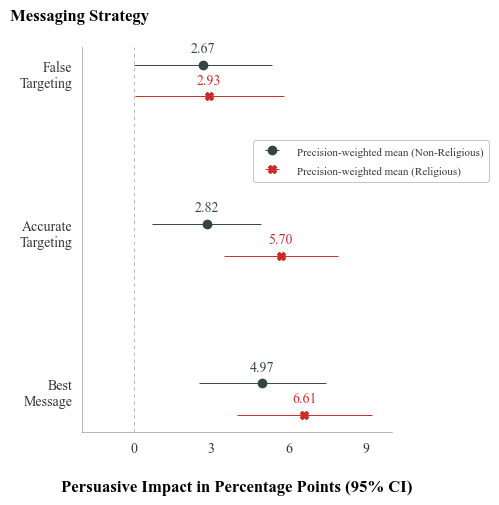

In [8]:
#FIGURE 1 (religion)
# Set the font to "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"

# Define constants based on results_df
ISSUES = ["Precision-weighted mean (Non-Religious)", "Precision-weighted mean (Religious)"]
NEW_LABELS = ['no microtargeting', 'microtargeting', 'false microtargeting']
COLOR_MAP = ['#354546', '#CB2C2A']
MARKERS = ['o', 'X']

# Set the plot dimensions
fig, ax = plt.subplots(figsize=(4,5))

# Initialize y_pos array for the base position of the first issue
base_y_pos = np.arange(len(NEW_LABELS), dtype=float)

# The vertical offset to apply for each subsequent issue
vertical_offset = 0.2  # Adjust as needed for spacing

# Iterate over the unique issues
for idx, (issue, color, marker) in enumerate(zip(ISSUES, COLOR_MAP, MARKERS)):
    # Calculate the y_pos for the current issue with an offset
    y_pos = base_y_pos - idx * vertical_offset
    
    # Filter the results_df for the current issue
    issue_data = results_df[results_df['Issue'] == issue]
    
    # Initialize a variable to control the addition of the label to the legend
    added_label = False
    
    # Set the line width based on the issue
    line_width = 0.7 if issue != "Precision-weighted mean" else 2
    
    # Iterate over the unique covariates
    for i, covariate in enumerate(NEW_LABELS):
        # Filter the issue_data for the current covariate
        covariate_data = issue_data[issue_data['Covariate'] == covariate]
        
        # Plot coefficients with error bars
        ax.errorbar(covariate_data['Coefficient'], y_pos[i], 
                    xerr=[covariate_data['Coefficient'] - covariate_data['95% CI Lower'], 
                          covariate_data['95% CI Upper'] - covariate_data['Coefficient']], 
                    fmt=marker, color=color, ecolor=color, capsize=0, linewidth=line_width,
                    label=issue if not added_label else "")
        
        # Ensure that the label is added only once
        added_label = True
        
        # Add coefficient labels
        ax.text(covariate_data['Coefficient'].values[0], y_pos[i] + 0.1, f"{covariate_data['Coefficient'].values[0]:.2f}", 
                va='center', ha='center', color=color, 
                bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

# Configure the plot
plt.axvline(0, color='#94999E', linestyle='--', linewidth=0.5, dashes=(5, 5))
plt.xlim(-2, 10)

ax.set_xlabel('Persuasive Impact in Percentage Points (95% CI)', fontsize=12, fontweight='bold', labelpad=17)
ax.set_yticks(base_y_pos- 0.05)
ax.set_yticklabels(['Best\nMessage', 'Accurate\nTargeting', 'False\nTargeting'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#94999E')
ax.spines['bottom'].set_color('#94999E')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.text(-2.1, len(NEW_LABELS) - .70, 'Messaging Strategy', rotation=0, va='center', ha='center', fontweight='bold', fontsize=12)
ax.tick_params(colors='#333333')
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Configure the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc=(0.55, 0.65), edgecolor='#94999E')
legend.get_frame().set_linewidth(0.5)

for text in legend.get_texts():
    text.set_color('#333333')
    text.set_fontsize(8)

# Display the plot
plt.show()

fig.savefig('figure1_religion.pdf', format='pdf', bbox_inches='tight')